# Разработка прогнозных моделей для отбора бурёнок в поголовье

В данном проекте обрабатывается запрос фермера, владельца молочного хозяйства «Вольный луг». Он хочет купить бурёнок, чтобы расширить поголовье стада коров. Для этого он заключил контракт с ассоциацией пастбищ «ЭкоФерма». Фермер хочет, чтобы каждая бурёнка давала не менее 6000 килограммов молока в год, а надой был вкусным — строго по его критериям.  
Требуется разработать модель машинного обучения, которая поможет ему управлять рисками и принимать объективное решение о покупке. «ЭкоФерма» готова предоставить подробные данные о своих коровах. Нужно создать две прогнозные модели для отбора бурёнок в поголовье: первая предсказывает объём удоя в кг, вторая вкус молока (вкусно или нет, бинарный признак).

# Оглавление:
---------------------------

1. [Загрузка библиотек и исходных данных](#1)
2. [Предобработка данных](#2)
3. [Исследовательский анализ данных](#3)
4. [Корреляционный анализ](#4)
5. [Обучение модели линейной регрессии](#5)
6. [Обучение модели логистической регрессии](#6)
6. [Итоговые выводы](#7)

<a name="1"></a>

## Загрузка библиотек и исходных данных 

In [1]:
!pip install regressors -q
!pip install phik -q

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import phik

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import r2_score, mean_squared_error as mse, mean_absolute_error as mae, accuracy_score, \
    precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from regressors import stats

import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

Загрузим данные и посмотрим на общую информацию:

In [3]:
ferma = pd.read_csv('datasets/ferma_main.csv', sep=';', decimal=',')
dad = pd.read_csv('datasets/ferma_dad.csv', sep=';')
cow = pd.read_csv('datasets/cow_buy.csv', sep=';', decimal=',')
ferma.info()
dad.info()
cow.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     634 non-null    int64  
 1   Удой, кг                               634 non-null    int64  
 2   ЭКЕ (Энергетическая кормовая единица)  634 non-null    float64
 3   Сырой протеин, г                       634 non-null    int64  
 4   СПО (Сахаро-протеиновое соотношение)   634 non-null    float64
 5   Порода                                 634 non-null    object 
 6   Тип пастбища                           634 non-null    object 
 7   порода папы_быка                       634 non-null    object 
 8   Жирность,%                             634 non-null    float64
 9   Белок,%                                634 non-null    float64
 10  Вкус молока                            634 non-null    object 
 11  Возрас

Как видно, ни в одной из таблиц нет пропущенных значений. Однако тип столбцов не всегда соответствует ожидаемому. Кроме того, названия столбцов довльно громоздкие и не соответствуют нижнему регистру. Изменим их, сохранив порядок столбцов из таблицы:

In [4]:
ferma.columns = ['id', 'удой', 'эке', 'протеин', 'спо', 'порода', 'тип_пастбища', 'порода_папы', 'жирность', 'белок',
                 'вкус_молока', 'возраст']
dad.columns = ['id', 'имя_папы']
cow.columns = ['порода', 'тип_пастбища', 'порода_папы', 'имя_папы', 'жирность', 'белок', 'возраст']

<a name="2"></a>

##  Предобработка данных 

Изменим типы столбцов в основном датасете: столбцы id, удой, протеин приведём к int. Также убедимся, что целевой признак вкус_молока имеет только два значения и приведём его к типу bool.  
Затем удалим дубликаты и присоединим таблицу с информацией о папе коровы к основной таблице.  
В конце проверим уникальные значения в столбцах возраст, порода_папы, порода, тип_пастбища. Значения *Айдиал* и *Айдиалл* в стоблце порода и значения *Равнинное* и *Равнинные* в столбце тип_пастбища судя по всему являются неявными дубликатами, так что их было решено заменить.  
Получим долю сохранившихся после предобработки значений, она составляет 99,21%. Это удовлетворительный результат.

In [5]:
start_size = len(ferma)
print(ferma['вкус_молока'].unique())
ferma['вкус_молока'].replace({'вкусно': True, 'не вкусно': False}, inplace=True)
print(ferma['вкус_молока'].unique())

print(ferma.duplicated().sum())
ferma.drop_duplicates(inplace=True)
ferma = ferma.merge(dad, on='id')
ferma.info()

print(ferma['возраст'].unique())
print(ferma['порода_папы'].unique())
print(ferma[ferma['порода_папы'] == 'Айдиалл']['имя_папы'].unique())
print(ferma[ferma['порода_папы'] == 'Айдиал']['имя_папы'].unique())
ferma['порода_папы'].replace({'Айдиалл': 'Айдиал'}, inplace=True)
print(ferma['порода'].unique())
print(ferma['тип_пастбища'].unique())
ferma['тип_пастбища'].replace({'Равнинные': 'Равнинное'}, inplace=True)

print(f'Доля оставшихся после предобработки значений: {len(ferma) / start_size:.2%}')

['вкусно' 'не вкусно']
[ True False]
5
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            629 non-null    int64  
 1   удой          629 non-null    int64  
 2   эке           629 non-null    float64
 3   протеин       629 non-null    int64  
 4   спо           629 non-null    float64
 5   порода        629 non-null    object 
 6   тип_пастбища  629 non-null    object 
 7   порода_папы   629 non-null    object 
 8   жирность      629 non-null    float64
 9   белок         629 non-null    float64
 10  вкус_молока   629 non-null    bool   
 11  возраст       629 non-null    object 
 12  имя_папы      629 non-null    object 
dtypes: bool(1), float64(4), int64(3), object(5)
memory usage: 59.7+ KB
['более_2_лет' 'менее_2_лет']
['Айдиал' 'Соверин' 'Айдиалл']
['Буйный' 'Геркулес' 'Барин' 'Соловчик']
['Буйный' 'Геркулес']
['Вис Бик Айдиа

<a name="3"></a>

## Исследовательский анализ данных 

Выведем основные статистические характеристики числовых переменных, а также построим графики распределения и ящики с усами. Как видно, переменные удой, эке, белок имеют скорее нормальное по форме распределение, а остальные интервальные переменные нет. Так, переменные спо и жирность имеют пик справа и длинный хвост слева, а протеин распределён почти линейно с отрицательным коэффициентом. Кроме того, был выявлен и удалён один выброс в переменной удой:

            id       удой      эке   протеин      спо  жирность    белок
count  629.000    629.000  629.000   629.000  629.000   629.000  629.000
mean   315.000   6188.750   14.544  1923.364    0.913     3.604    3.076
std    181.721   1644.795    1.306   182.956    0.032     0.169    0.003
min      1.000   5204.000   10.900  1660.000    0.840     2.990    3.069
25%    158.000   5751.000   13.500  1771.000    0.890     3.590    3.074
50%    315.000   6133.000   14.700  1888.000    0.930     3.650    3.076
75%    472.000   6501.000   15.600  2062.000    0.940     3.720    3.077
max    629.000  45616.000   16.800  2349.000    0.960     3.750    3.085


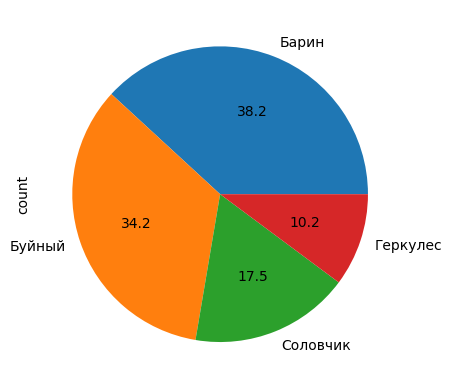

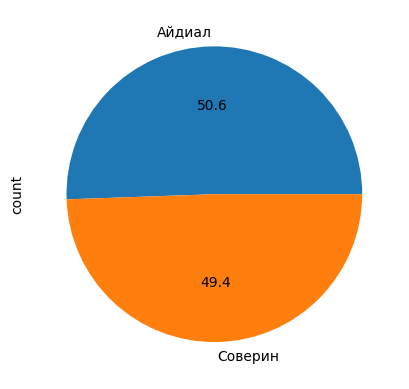

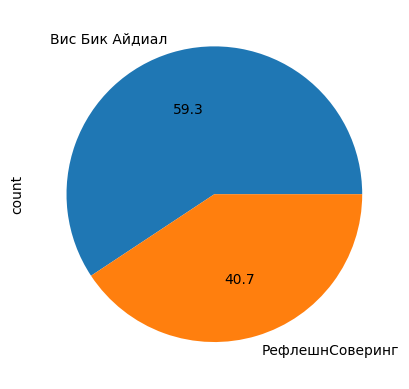

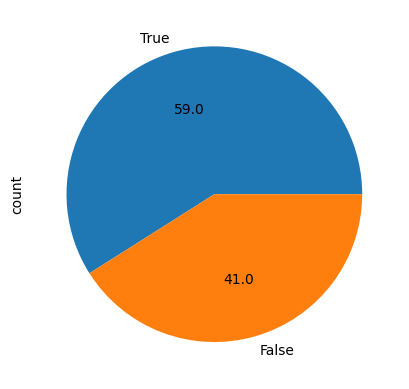

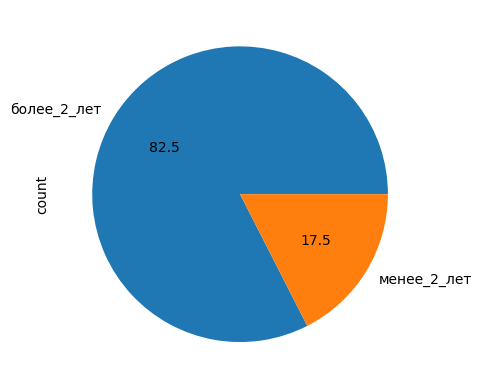

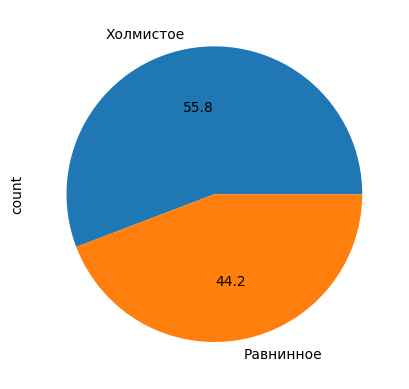

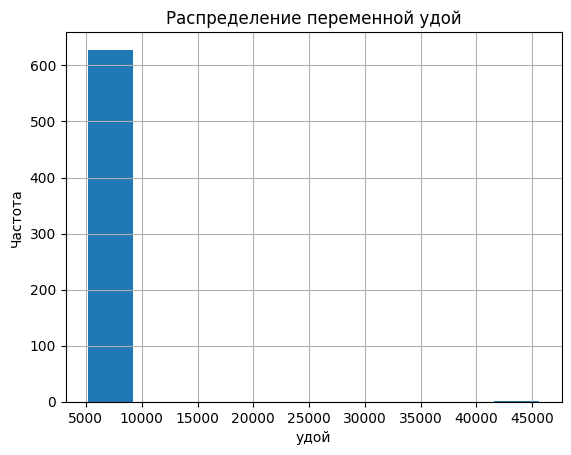

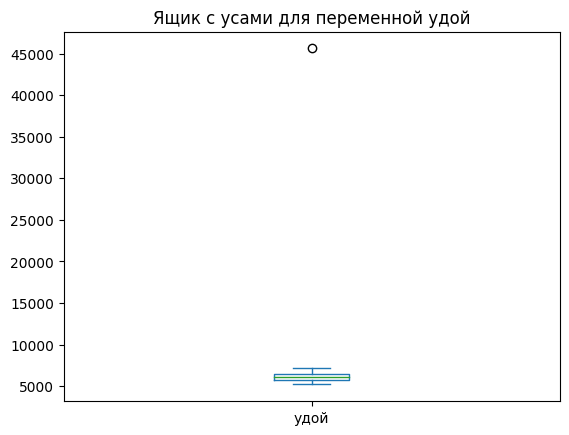

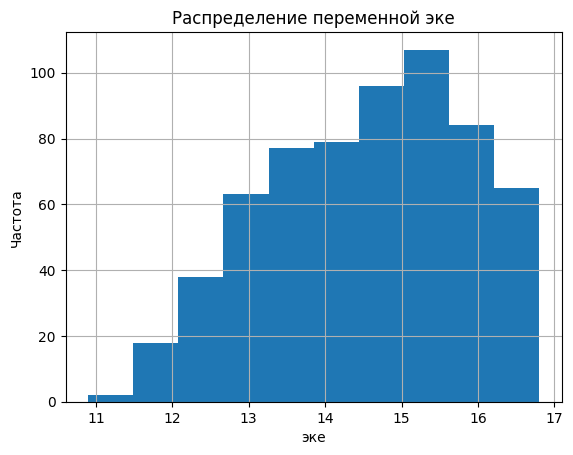

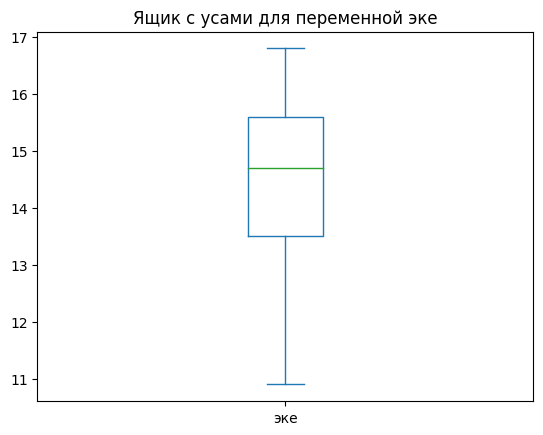

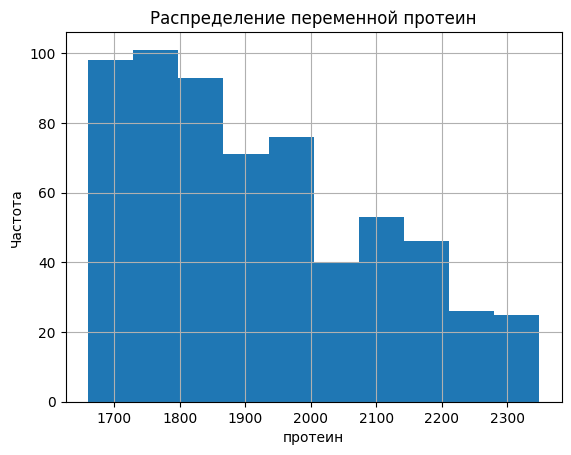

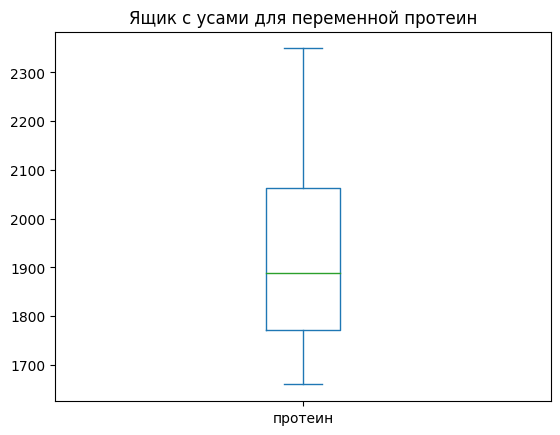

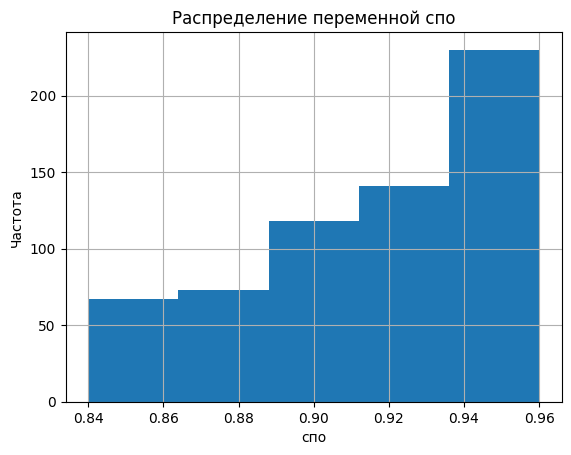

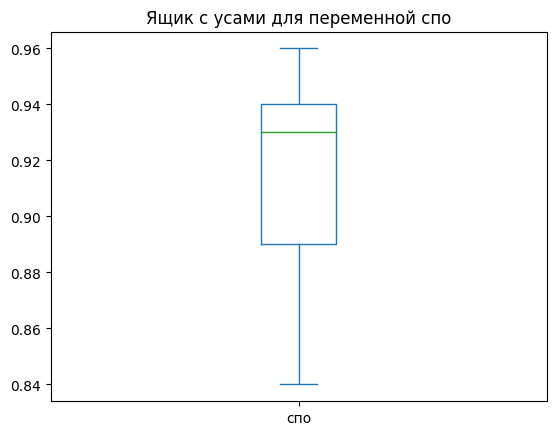

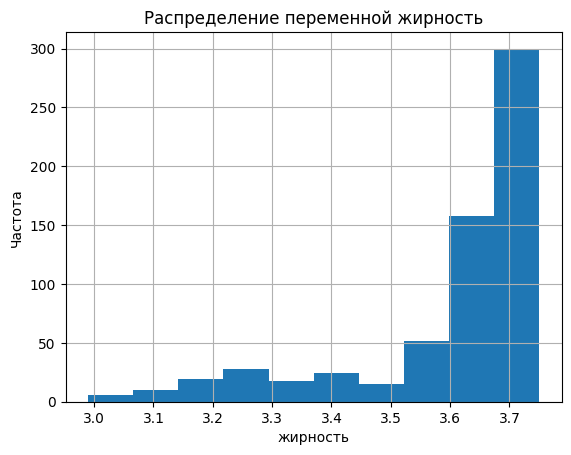

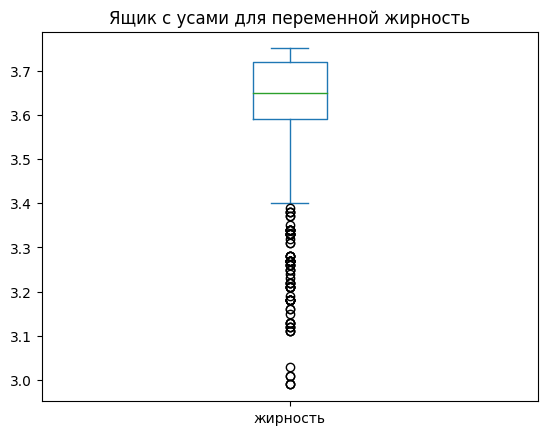

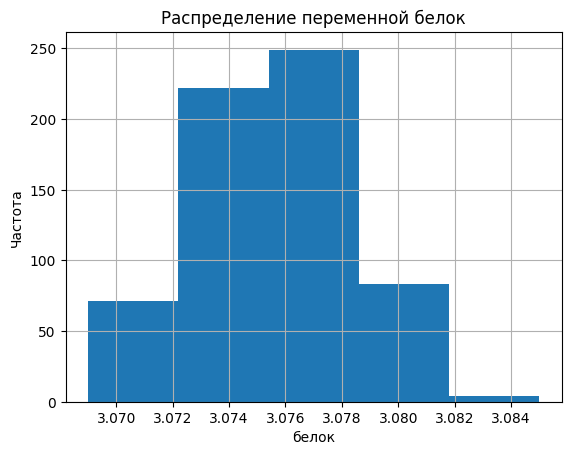

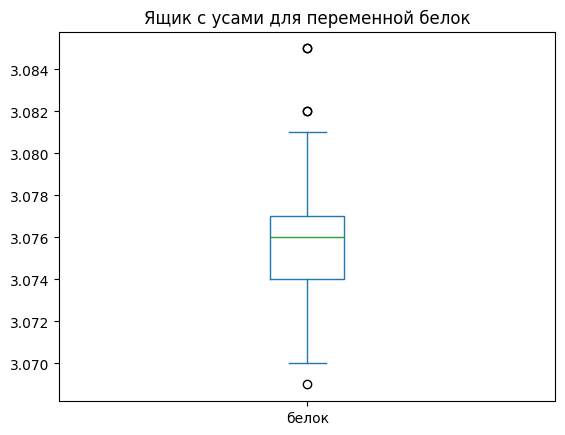

16     45616
70      7222
135     7207
296     7201
294     7197
593     7174
46      7173
176     7141
264     7133
194     7113
Name: удой, dtype: int64


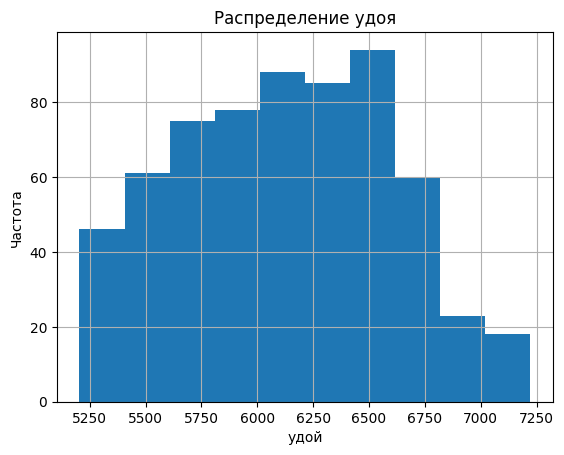

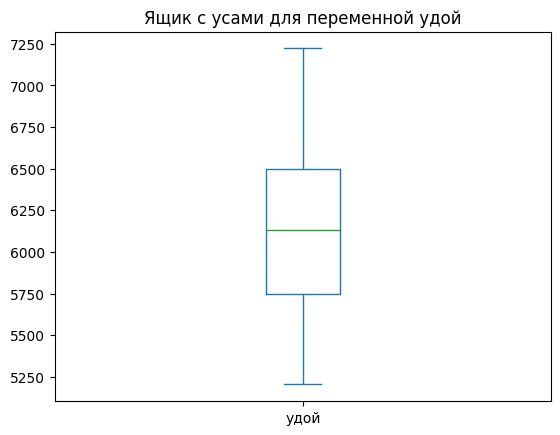

In [6]:
print(ferma.describe().round(3))
ctg_columns = ['имя_папы', 'порода_папы', 'порода', 'вкус_молока', 'возраст', 'тип_пастбища']
for name in ctg_columns:   
    ferma[name].value_counts().plot(kind='pie', autopct='%.1f')
    plt.show()

num_columns = ['удой', 'эке', 'протеин', 'спо', 'жирность', 'белок']
bins = [10, 10, 10, 5, 10, 5]
for name, b in zip(num_columns, bins):   
    ferma[name].hist(bins=b)
    plt.title(f'Распределение переменной {name}')
    plt.xlabel(name)
    plt.ylabel('Частота')
    plt.show()
    ferma[name].plot.box()
    plt.title(f'Ящик с усами для переменной {name}')
    plt.show()
print(ferma['удой'].sort_values(ascending=False).head(10))
ferma = ferma[ferma['удой'] < 10000]
ferma['удой'].hist()
plt.title('Распределение удоя')
plt.xlabel('удой')
plt.ylabel('Частота')
plt.show()
ferma['удой'].plot.box()
plt.title(f'Ящик с усами для переменной удой')
plt.show()


<a name="4"></a>

## Корреляционный анализ

Проанализируем корреляцию между признаками. Так как спо, жирность и протеин распределены не нормально посчитаем коэффициент Спирмена. Он показывает наличие корреляции жирности с удоем, спо и эке на уровне 0,69-0,7. Кроме того, эке, спо и удой коррелируют между собой с коэффициентами 0,74-0,79. Дополнительно посчитаем коэффициент корреляции Фи, чтобы проверить связь с категориальными признаками. Можно отметить, что порода_папы и имя_папы коррелируют на урове 0,98. Возраст и удой имеют коэффициент 1, вкус молока коррелирует с спо (0,57). Порода и имя папы имеют небольшую корреляцию с удоем (0,43-0,52).  
Теперь построим диаграмму рассеяния удоя с потенциальными предикторами. Судя по всему, эке и удой связаны нелинейно, а соотношение протеина и удоя имеет небольшой линейный тренд, но очень заметную дисперсию. Удой и спо связаны скорее пороговым образом (переход к большим значениям удоя в районе спо 0,9-0,92), холмистый тип пастбищ показывает бóльшие пиковые значения удоя, но без значительной разницы в среднем, порода папы *Айдиал* явно располагает к немного большим значениям удоя, а коровы старше двух лет однозначно дают в среднем заметно больше молока:

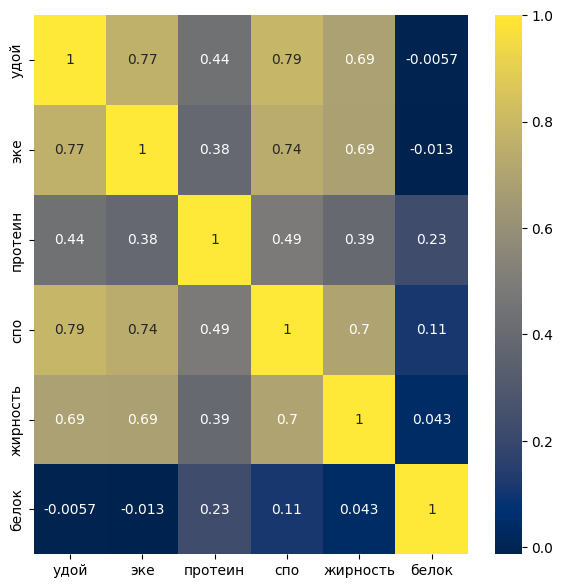

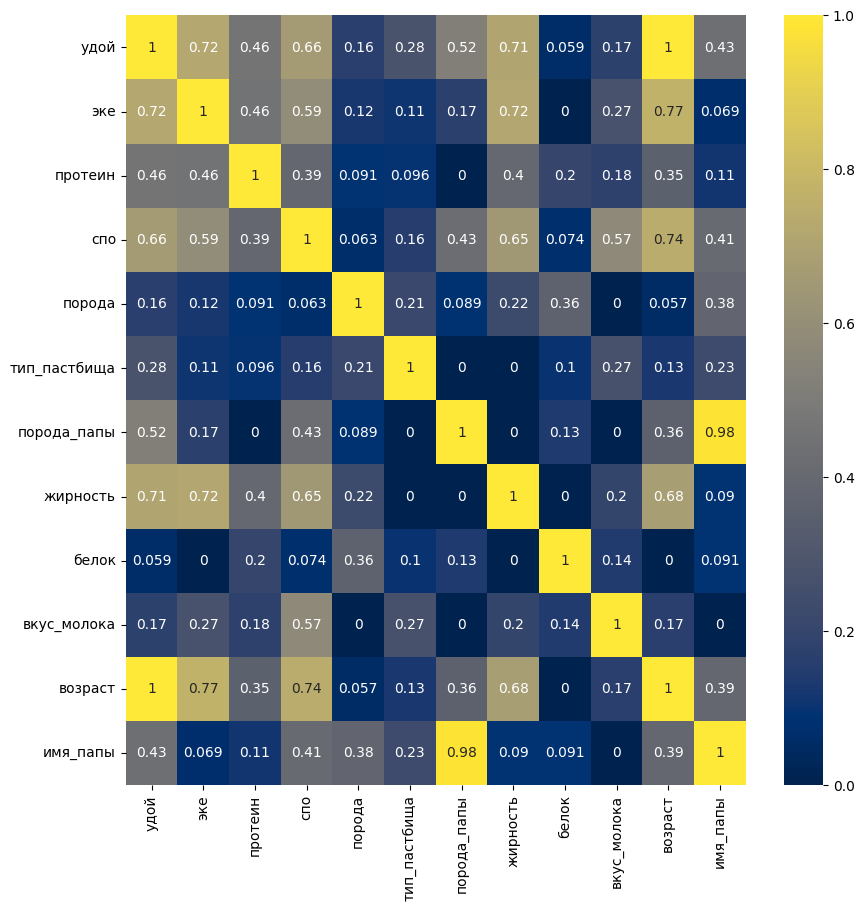

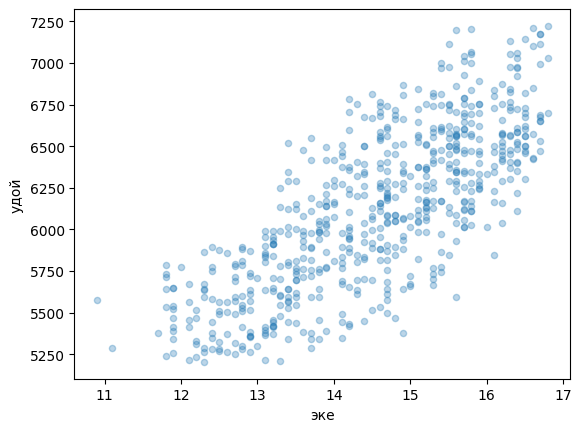

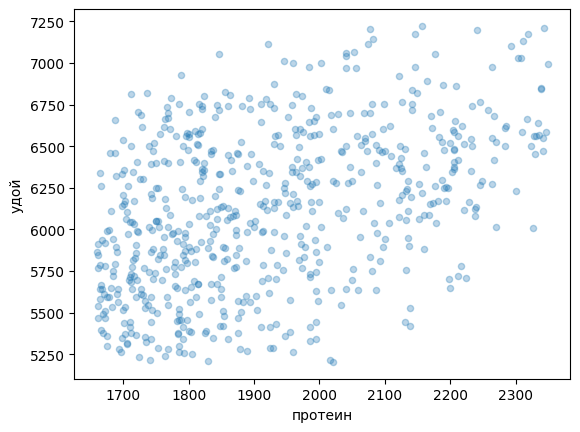

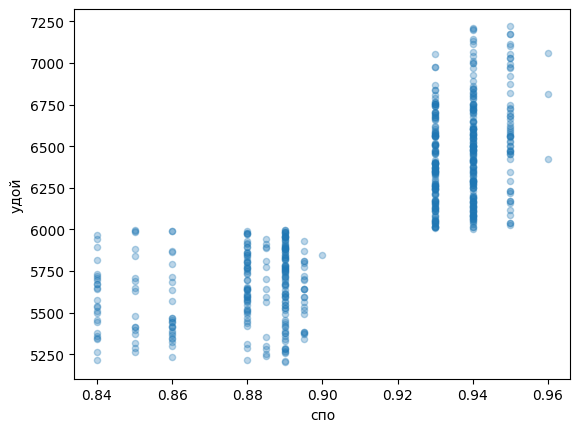

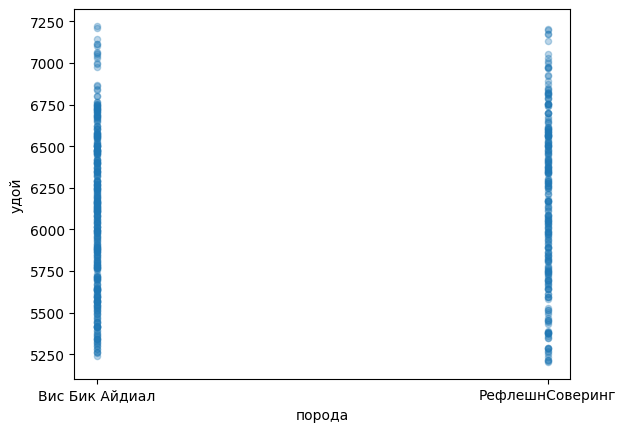

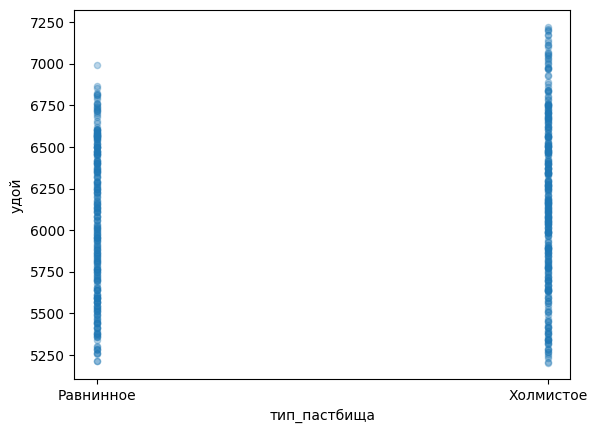

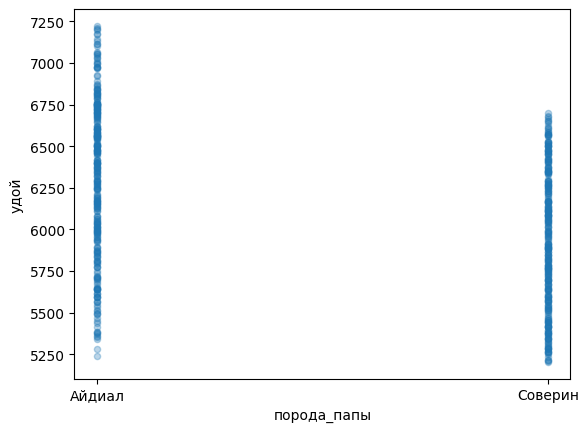

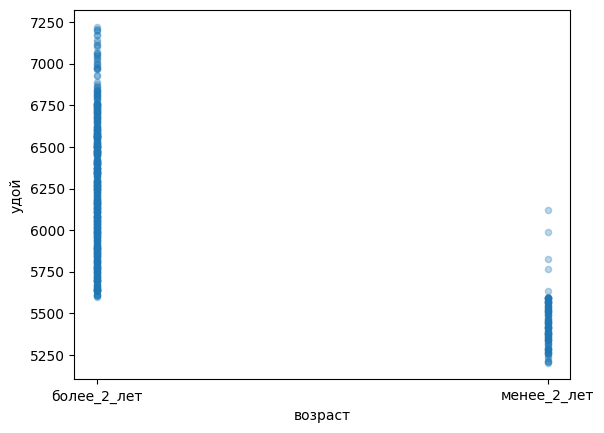

In [7]:
plt.figure(figsize=(7, 7))
sns.heatmap(ferma[num_columns].corr(method='spearman'), annot=True, cmap='cividis')
plt.show()
plt.figure(figsize=(10, 10))
sns.heatmap(ferma.drop('id', axis=1).phik_matrix(interval_cols=num_columns), annot=True, cmap='cividis')
plt.show()

preds = ['эке', 'протеин', 'спо', 'порода', 'тип_пастбища', 'порода_папы', 'возраст']
for pred in preds:
    ferma.plot(pred, 'удой', kind='scatter', alpha=0.3)
    plt.show()


<a name="5"></a>

## Обучение модели линейной регрессии 

In [8]:
class MLPipeline:
    def __init__(self):
        self.cible = None

    
    def prepare_data(self, df, ctg_columns, num_columns, cible):
        self.ctg_columns = ctg_columns
        self.num_columns = num_columns
        self.cible = cible
        X = df[ctg_columns + num_columns]
        y = df[cible]
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
        self.encoder = OneHotEncoder(drop='first', sparse_output=False)
        self.ctg_transform = [ctg_name + f'_{i}' for ctg_name in ctg_columns for i in range(len(X[ctg_name].unique()) - 1)]
        X_train.loc[:, self.ctg_transform] = self.encoder.fit_transform(X_train[ctg_columns])
        X_train.drop(ctg_columns, axis=1, inplace=True)
        X_test.loc[:, self.ctg_transform] = self.encoder.transform(X_test[ctg_columns])
        X_test.drop(ctg_columns, axis=1, inplace=True)
        self.scaler = StandardScaler()
        X_train.loc[:, num_columns] = self.scaler.fit_transform(X_train[num_columns])
        X_test.loc[:, num_columns] = self.scaler.transform(X_test[num_columns])
        return X_train, X_test, y_train, y_test


    def build_model(self, X_train, X_test, y_train, y_test, model_type):
        model = model_type()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        if model_type == LinearRegression:
            stats.summary(model, X_train, y_train, X_train.columns)
            print('R2 =', round(r2_score(y_test, y_pred), 3))
            print('MSE =', round(mse(y_test, y_pred), 3))
            print('RMSE =', round(mse(y_test, y_pred, squared=False), 3))
            print('MAE =', round(mae(y_test, y_pred), 3))
            resid = y_test - y_pred
            plt.hist(resid, bins=12)
            plt.title('Распределение остатков')
            plt.xlabel('Остатки')
            plt.ylabel('Частота')
            plt.show()
            plt.scatter(y_pred, resid)
            plt.title('Дисперсия остатков')
            plt.xlabel('Предсказания')
            plt.ylabel('Остатки')
            plt.show()
        elif model_type == LogisticRegression:
            print('Accuracy =', round(accuracy_score(y_test, y_pred), 3))
            print('Precision =', round(precision_score(y_test, y_pred), 3))
            print('Recall =', round(recall_score(y_test, y_pred), 3))
            disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred), display_labels=model.classes_)
            disp.plot()
            plt.show()
        return model


    def prepare_predict(self, df):
        if self.cible is None:
            print('Данные ещё не подготовлены')
            return
        X = df[self.ctg_columns + self.num_columns]
        X.loc[:, self.ctg_transform] = self.encoder.transform(X[self.ctg_columns])
        X.loc[:, self.num_columns] = self.scaler.transform(X[self.num_columns])
        return X.drop(self.ctg_columns, axis=1)


def linear_data(df):
    df.loc[:, 'спо_2'] = (df['спо'] > 0.92).astype(int)
    df.loc[:, 'эке_квадрат'] = df['эке'] ** 2

Построим модель линейной регрессии для предсказания значения удоя.  
Первая модель использует в качестве предикторов переменные тип_пастбища, порода, порода_папы, возраст, эке, протеин, спо. $R^2$ равен 0,78, среднеквадратичная ошибка равна 209 кг, а средняя абсолютная - 164 кг. Из этого можно предположить, что имеются выбросы и это подтверждается на графике остатков - в районе предсказаний 6000-6700 имеется несколько заметных выбросов с ошибкой в 500-600 кг, один из них особенно сильный. Дисперсия остатков также не совсем постоянна и несколько увеличивается для предсказаний более 6000 кг удоя. При этом распределение остатков центрировано в нуле, хотя и не совсем симметрично:


Residuals:
      Min        1Q    Median       3Q       Max
5031.4118 5797.0831 6274.1047 6463.748 6876.8272


Coefficients:
                   Estimate  Std. Error   t value   p value
_intercept      6262.396810   16.604139  377.1588  0.000000
эке              156.863493   14.051661   11.1633  0.000000
протеин           50.601347   10.621176    4.7642  0.000003
спо              162.478018   14.546598   11.1695  0.000000
тип_пастбища_0    50.992039   18.571014    2.7458  0.006268
порода_0          -1.006906   19.504400   -0.0516  0.958850
порода_папы_0   -240.316969   19.443101  -12.3600  0.000000
возраст_0       -237.101221   31.088062   -7.6268  0.000000
---
R-squared:  0.81363,    Adjusted R-squared:  0.81081
F-statistic: 288.76 on 7 features
R2 = 0.784
MSE = 43887.015
RMSE = 209.492
MAE = 164.242


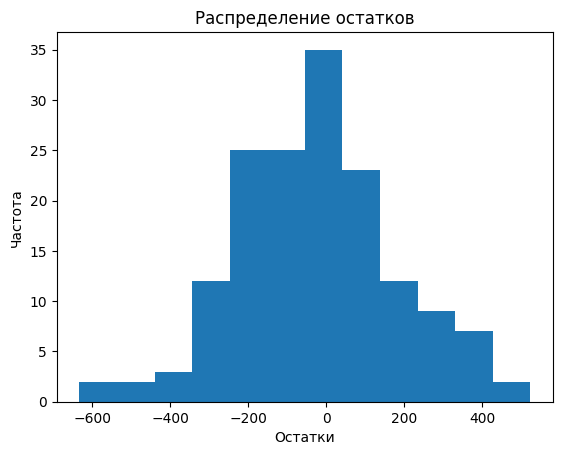

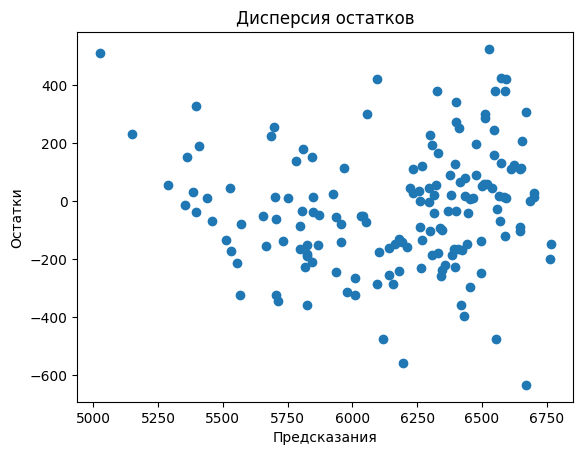

In [9]:
ctg_columns = ['тип_пастбища', 'порода', 'порода_папы', 'возраст']
num_columns = ['эке', 'протеин', 'спо']
cible = 'удой'
model_type = LinearRegression
YieldPipeline = MLPipeline()

model1 = YieldPipeline.build_model(*YieldPipeline.prepare_data(ferma, ctg_columns, num_columns, cible), model_type)

Для второй модели на основании диаграмм рассеяния произведена линеаризация данных, признак эке заменён на эке_квадрат, а спо на спо_2 (бинарный признак с порогом 0,92). Теперь $R^2$ равен 0,82, среднеквадратичная ошибка равна 192 кг, а средняя абсолютная - 149 кг. Это свидетельствует о лучшем качестве модели, кроме того дисперсия остатков стала заметно более постоянной, заметно выделяется лишь один выброс. Тем не менее, распределение остатков остаётся асимметричным и даже немного сдвинуто влево от нуля:  

Residuals:
     Min        1Q    Median       3Q       Max
5232.363 5751.6633 6306.7696 6477.643 6829.5562


Coefficients:
                   Estimate  Std. Error   t value   p value
_intercept      6253.053463   15.618324  400.3665  0.000000
протеин           49.131219    9.882822    4.9714  0.000001
эке_квадрат      154.179906   12.613404   12.2235  0.000000
спо_2            185.888937   13.038081   14.2574  0.000000
тип_пастбища_0    32.637849   17.414213    1.8742  0.061522
порода_0           4.399432   18.297823    0.2404  0.810098
порода_папы_0   -211.463067   18.595024  -11.3720  0.000000
возраст_0       -224.709410   29.069975   -7.7299  0.000000
---
R-squared:  0.83584,    Adjusted R-squared:  0.83336
F-statistic: 336.77 on 7 features
R2 = 0.818
MSE = 37030.911
RMSE = 192.434
MAE = 149.04


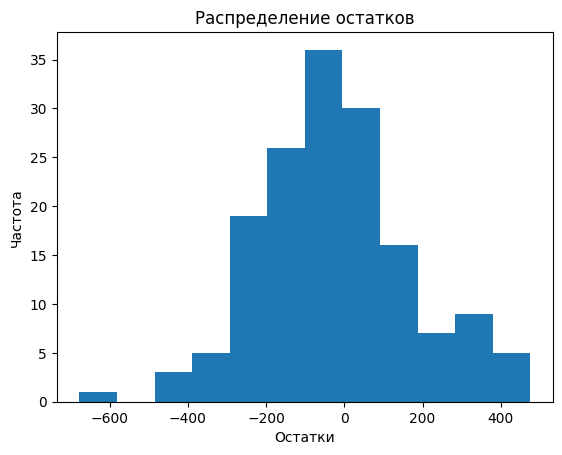

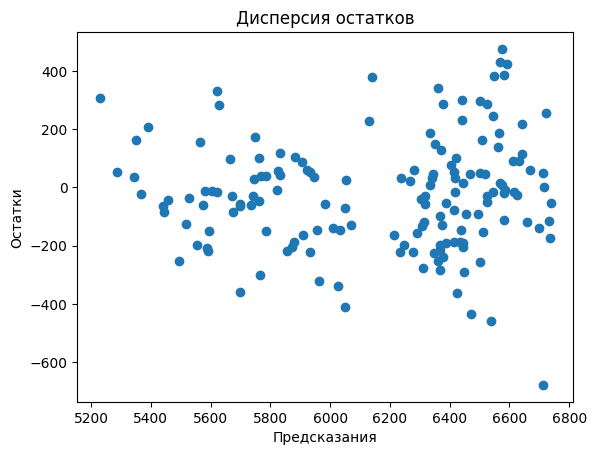

In [10]:
linear_data(ferma)
num_columns.remove('эке')
num_columns.append('эке_квадрат')
num_columns.remove('спо')
num_columns.append('спо_2')
model2 = YieldPipeline.build_model(*YieldPipeline.prepare_data(ferma, ctg_columns, num_columns, cible), model_type)

Для последней модели добавлен придиктор имя_папы. Так как он сильно коррелирует с предиктором порода_папы, последний был убран из модели. Подобная замена позволяет слегка улучшить качество модели: $R^2$ равен 0,83, среднеквадратичная ошибка равна 188 кг, а средняя абсолютная - 145 кг. Что важнее, распределение остатков лучше центрировано возле нуля, дисперсия остатков остаётся схожей. Пожалуй, именно эта модель лучшая: 

Residuals:
      Min        1Q    Median        3Q       Max
5221.2844 5738.3906 6293.0318 6476.5764 6873.6633


Coefficients:
                   Estimate  Std. Error   t value   p value
_intercept      6004.671113   16.939183  354.4841  0.000000
протеин           52.144918    9.396037    5.5497  0.000000
эке_квадрат      162.347321   11.990847   13.5393  0.000000
спо_2            173.790349   12.375148   14.0435  0.000000
тип_пастбища_0    48.999099   16.608293    2.9503  0.003333
порода_0          14.738282   17.456894    0.8443  0.398950
возраст_0       -194.015429   27.553680   -7.0414  0.000000
имя_папы_0       261.888581   20.640990   12.6878  0.000000
имя_папы_1       293.042604   31.228690    9.3838  0.000000
имя_папы_2        23.443140   23.196640    1.0106  0.312715
---
R-squared:  0.85300,    Adjusted R-squared:  0.85013
F-statistic: 297.23 on 9 features
R2 = 0.827
MSE = 35316.004
RMSE = 187.926
MAE = 144.638


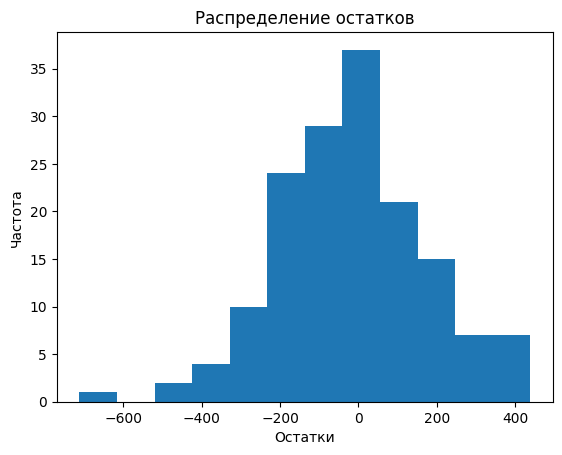

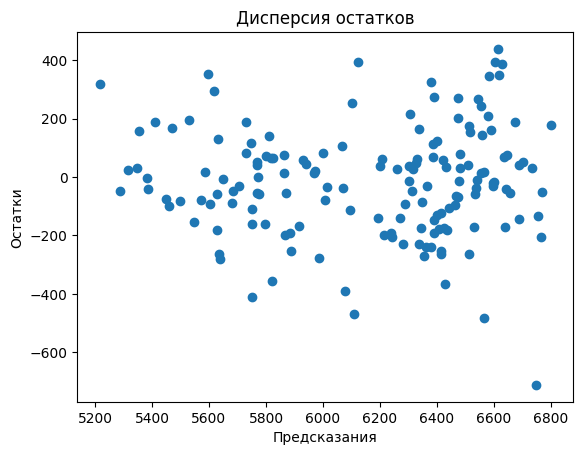

In [11]:
ctg_columns.append('имя_папы')
ctg_columns.remove('порода_папы')
X_train, X_test, y_train, y_test = YieldPipeline.prepare_data(ferma, ctg_columns, num_columns, cible)
model3 = YieldPipeline.build_model(X_train, X_test, y_train, y_test, model_type)

Теперь предскажем значения удоя для коров с "Экофермы" (датасет cow) лучшей моделью. Исправим ошибку в данных: значения переменной тип_пастбища в этом наборе данных написаны с маленькой буквы, тогда как в основном наборе данных - с большой. Применим новые нормы кормления бурёнок: значения эке, протеина и спо по плану будут на 5% выше, чем в среднем в уже имеющемся поголовье. Как видно, все предсказанные значения с запасом превышают требуемое значение 6000 кг. Вероятно, это связано как раз с новой, усиленной системой кормления: 

In [12]:
cow.loc[:, 'тип_пастбища'] = cow['тип_пастбища'].str.capitalize()
cow.loc[:, 'эке'] = ferma['эке'].mean() * 1.05
cow.loc[:, 'протеин'] = ferma['протеин'].mean() * 1.05
cow.loc[:, 'спо'] = ferma['спо'].mean() * 1.05
linear_data(cow)

X = YieldPipeline.prepare_predict(cow)

y_pred = model3.predict(X)
res = pd.DataFrame({'удой': y_pred}).round(0)
print(res)

      удой
0   6608.0
1   6334.0
2   6281.0
3   6592.0
4   6543.0
5   6380.0
6   6608.0
7   6528.0
8   6281.0
9   6398.0
10  6339.0
11  6574.0
12  6608.0
13  6121.0
14  6281.0
15  6592.0
16  6339.0
17  6380.0
18  6528.0
19  6543.0


<a name="6"></a>

## Обучение модели логистической регрессии 

Построим модель логистической регрессии для предсказания значения переменной вкус_молока.  
Эта модель использует в качестве предикторов переменные тип_пастбища, порода, имя_папы, возраст, эке_квадрат, протеин, спо_2, жирность, белок. Accuracy равен 0,631, precision равен 0,623, а recall - 0,864.  
Так как покупка коровы является серьёзным и долгосрочным вложением, ложноположительная ошибка будет иметь более негатиные последствия, чем ложноотрицательная. Иными словами, гораздо важнее добиться хороших результатов для метрики precision. Рассчитаем, какой порог классификации приводит к полному отсутствию ложноположительных ошибок (по требованию заказчика precision равен 1). Этот порог равен 0,87.


In [13]:
logistic_features_numeric=['fat_percents','protein_percents','energy_feed_unit_square', 'protein_g']
logistic_features_category=['sugar_protein_ratio_cat','dad_breed','age','pasture_type']

Accuracy = 0.631
Precision = 0.623
Recall = 0.864


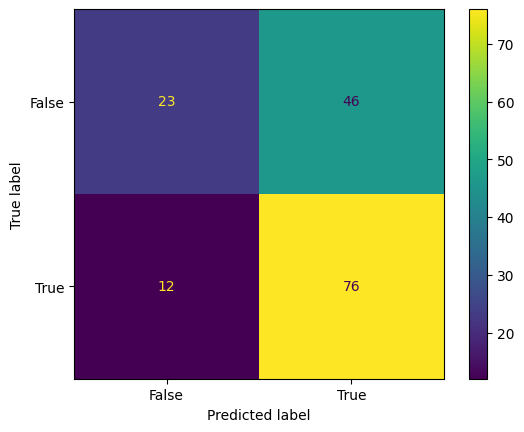

   Порог  Precision
0    0.5   0.662791
1    0.6   0.704918
2    0.7   0.809160
3    0.8   0.884615
4    0.9   1.000000
   Порог  Precision
0   0.80   0.884615
1   0.81   0.906977
2   0.82   0.888889
3   0.83   0.937500
4   0.84   0.960000
5   0.85   0.958333
6   0.86   0.923077
7   0.87   1.000000
8   0.88   1.000000
9   0.89   1.000000


In [14]:
def check_precision(model, d, u, n=10):
    seuil = np.linspace(d, u, num=n, endpoint=False)
    est = [precision_score(y_train, np.vectorize(lambda x: x > s)(model.predict_proba(X_train)[:, 1])) for s in seuil]
    print(pd.DataFrame({'Порог': seuil, 'Precision': est}))


ctg_columns = ['тип_пастбища', 'порода', 'возраст', 'имя_папы']
num_columns = ['эке_квадрат', 'протеин', 'спо_2', 'жирность', 'белок', 'удой']
cible = 'вкус_молока'
model_type = LogisticRegression
ferma['удой'] = model3.predict(YieldPipeline.prepare_predict(ferma))
cow['удой'] = model3.predict(YieldPipeline.prepare_predict(cow))

TastePipeline = MLPipeline()
X_train, X_test, y_train, y_test = TastePipeline.prepare_data(ferma, ctg_columns, num_columns, cible)
model = TastePipeline.build_model(X_train, X_test, y_train, y_test, model_type)
check_precision(model, 0.5, 1, 5)
check_precision(model, 0.8, 0.9)


 <a name="7"></a>

## Итоговые выводы

Посмотрим на итоговые предсказания удоя и вкуса молока. Затем отберём тех коров, для которых предсказанный удой превышает требуемый уровень в 6000 кг, а хороший вкус предсказан с минимальным риском (как было показано выше, порог классификации в таком случае составляет 0,87). Конечно, таких коров нет среди предложенных.  
Можно предложить сделать выбор с вероятностью 80% (precision равен 0,8, требуемый порог классификации 0,69). В таком случае фермер с довольно малым риском может купить 4 коровы с id 0, 6, 9 и 16. При этом корова 16 хуже прочих и по удою, и по уверенности в хорошем вкусе; её покупка нерациональна. Среди оставшихся трёх коров 0 и 6 одинаковы по предсказанным характеристикам между собой, а уверенность в хорошем вкусе коровы 9 наивысшая (0,74 против 0,707 у двух остальных) при чуть меньшем удое (6398 против 6608).
На хорошую точность модель регрессии положительно повлияла линеаризация признаков и добавление нового признака. Вероятно, имея информацию о большем количестве коров, добавив новые признаки или установив более точно характер связи уже имеющихся предикторов с целевым, в будущем удастся ещё улучшить точность построенных моделей. Кроме того, возможно, с учётом усиленного питания фермеру стоит повысить требования к удою коров и, наоборот, понизить требуемый уровень уверенности во вкусе молока до достижимых показателей. Альтернативный вариант - найти более объективную метрику, чем субъективно и бинарно понимаемый вкус.

In [15]:
X = TastePipeline.prepare_predict(cow)
y_pred = model.predict_proba(X)[:, 1]
print('Предсказанная вероятность хорошего вкуса для коров «ЭкоФермы» (precision = 1):\n',  pd.Series(y_pred).round(2), sep='')
res['вкус'] = np.vectorize(lambda x: x > 0.87)(y_pred)
print('Итоговые предсказания обеих моделей:\n',  res, sep='')
print('Подходящие под критерии коровы:\n', res[(res['вкус'])&(res['удой']>=6000)], sep='')
check_precision(model, 0.6, 0.7)

print('Предсказанная вероятность хорошего вкуса для коров «ЭкоФермы» (precision=0.8):\n',  pd.Series(y_pred), sep='')
res['вкус'] = np.vectorize(lambda x: x > 0.68)(y_pred)
print('Итоговые предсказания обеих моделей:\n',  res, sep='')
print('Подходящие под критерии коровы:\n', res[(res['вкус'])&(res['удой']>=6000)], sep='')

Предсказанная вероятность хорошего вкуса для коров «ЭкоФермы» (precision = 1):
0     0.71
1     0.67
2     0.57
3     0.36
4     0.55
5     0.11
6     0.71
7     0.67
8     0.57
9     0.74
10    0.16
11    0.52
12    0.10
13    0.66
14    0.57
15    0.46
16    0.69
17    0.10
18    0.43
19    0.55
dtype: float64
Итоговые предсказания обеих моделей:
      удой   вкус
0   6608.0  False
1   6334.0  False
2   6281.0  False
3   6592.0  False
4   6543.0  False
5   6380.0  False
6   6608.0  False
7   6528.0  False
8   6281.0  False
9   6398.0  False
10  6339.0  False
11  6574.0  False
12  6608.0  False
13  6121.0  False
14  6281.0  False
15  6592.0  False
16  6339.0  False
17  6380.0  False
18  6528.0  False
19  6543.0  False
Подходящие под критерии коровы:
Empty DataFrame
Columns: [удой, вкус]
Index: []
   Порог  Precision
0   0.60   0.704918
1   0.61   0.717391
2   0.62   0.730942
3   0.63   0.748792
4   0.64   0.751269
5   0.65   0.771739
6   0.66   0.765714
7   0.67   0.785276
8   0.68   